In [1]:
# !pip install torch-geometric
# !pip install torch-geometric-temporal

In [2]:
from traffic_datasets import PemsBayDatasetLoaderSingleValue
from models import TrafficA3TGCNSingleShot, TrafficA3TGCN_LSTM
from torch_geometric_temporal.signal import temporal_signal_split

In [3]:
import torch
import torch.nn as nn
from torch.optim import Adam

In [4]:
dataloader = PemsBayDatasetLoaderSingleValue()

In [5]:
NY_TIME_INTERVAL = 15 # the new york traffic data comes in 15 minute intervals
PEMS_BAY_INTERVAL = 5 # the SF pems bay traffic sensor data comes in 5 minutes intervals
METRLA_INTERVAL = 5 # the SF pems bay traffic sensor data comes in 5 minutes intervals

TIME_INTERVAL = PEMS_BAY_INTERVAL # change this!

# use the past 60 minutes of data to predict the next 15 minutes of traffic
num_in_minutes = 60
num_out_minutes = 30

# calculation
num_in = num_in_minutes//TIME_INTERVAL
num_out = num_out_minutes//TIME_INTERVAL

In [6]:
dataset, _ , _, _ = dataloader.get_dataset(num_in, num_out)
print(f"Number of {TIME_INTERVAL} minute predictor intervals: {num_in}")
print(f"Number of {TIME_INTERVAL} minute estimated intervals: {num_out}")

Number of 5 minute predictor intervals: 12
Number of 5 minute estimated intervals: 6


In [7]:
dataset[0]

Data(x=[325, 2, 12], edge_index=[2, 2694], edge_attr=[2694], y=[325, 6])

In [8]:
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

In [9]:
device = torch.device('cuda') # cuda:0, cuda:1, cuda:2

In [10]:
# define hyperparameters
lr = 0.01
weight_decay = 0.000
dropout = 0.1
batch_size = 64
num_epochs = 10

In [11]:
# define model
model = TrafficA3TGCNSingleShot(
    node_features=2, 
    periods_in=num_in, 
    periods_out = num_out, 
    dropout_rate = dropout, 
    batch_size=batch_size
).to(device)


# model = TrafficA3TGCN_LSTM(
#     node_features=2, 
#     node_out_features=1,
#     periods_in=num_in, 
#     periods_out = num_out, 
#     dropout_rate = dropout, 
#     batch_size=batch_size
# ).to(device)


In [12]:
# define optimizer and loss function
optimizer = Adam(model.parameters(), lr = lr, weight_decay = weight_decay)
criterion = nn.L1Loss(reduction="mean") # can change reduction="sum" and see what happens

In [13]:
iterable_train = list(iter(dataset))

In [14]:
batch_instances = iterable_train[0:0+batch_size]
# (batch_size, num_nodes, node_in_features, periods_in)
X_batch = torch.stack([instance.x for instance in batch_instances]).to(device)
# (batch_size, num_nodes, node_out_features, periods_out)
Y_batch = torch.stack([instance.y for instance in batch_instances]).to(device)
print(f"X Batch Shape: {X_batch.shape}")
edge_index_batch = batch_instances[0].edge_index.to(device)
print(f"Edge Index Shape: {edge_index_batch.shape}")
edge_features_batch = batch_instances[0].edge_attr.to(device)
print(f"Edge Features Shape: {edge_features_batch.shape}")
# (batch_size, num_nodes, node_out_features, periods_out)
y_hat = model(X_batch, edge_index_batch, edge_features_batch)
print(f"Y hat Batch Shape (before squeeze): {y_hat.shape}")
# for this specific example, when node_out_features=1, I have to speeze the 2nd (really 3rd) dimension
# y_hat = y_hat.squeeze(2) # ONLY FOR LSTM
print(f"Y Batch Shape: {Y_batch.shape}")
print(f"Y hat Batch Shape (after squeeze): {y_hat.shape}")

X Batch Shape: torch.Size([64, 325, 2, 12])
Edge Index Shape: torch.Size([2, 2694])
Edge Features Shape: torch.Size([2694])
Y hat Batch Shape (before squeeze): torch.Size([64, 325, 6])
Y Batch Shape: torch.Size([64, 325, 6])
Y hat Batch Shape (after squeeze): torch.Size([64, 325, 6])


/opt/mambaforge/envs/cs152/lib/python3.10/site-packages/torch/nn/functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [15]:
from tqdm import tqdm_notebook, tqdm_gui
import tqdm
from random import shuffle
from fastprogress.fastprogress import progress_bar, master_bar
import matplotlib.pyplot as plt
from jupyterthemes import jtplot

jtplot.style(context="talk")
mb = master_bar(range(num_epochs))
mb.names = ["Train Loss"]
mb.main_bar.comment = f"Epochs"

In [16]:
def update_plots(mb, train_losses, valid_losses, epoch, num_epochs):

    # Update plot data
    max_loss = max(max(train_losses), max(valid_losses))
    min_loss = min(min(train_losses), min(valid_losses))

    x_margin = 0.2
    x_bounds = [0 - x_margin, num_epochs + x_margin]

    y_margin = 0.1 * (max_loss - min_loss)
    y_bounds = [min_loss - y_margin, max_loss + y_margin]

    train_xaxis = torch.linspace(0, epoch + 1, len(train_losses))
    valid_xaxis = torch.linspace(0, epoch + 1, len(valid_losses))
    graph_data = [[train_xaxis, train_losses], [valid_xaxis, valid_losses]]

    mb.update_graph(graph_data, x_bounds, y_bounds)

Epoch 0:   0%|          | 0/652 [00:00<?, ?it/s]

/opt/mambaforge/envs/cs152/lib/python3.10/site-packages/torch/nn/functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch 0 Val:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 0 Train Loss: 0.63296698 | Val Loss: 0.60494364


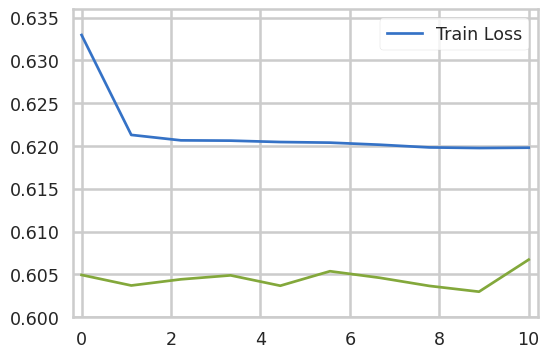

Epoch 1:   0%|          | 0/652 [00:00<?, ?it/s]

Epoch 1 Val:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 1 Train Loss: 0.62130009 | Val Loss: 0.60371153


Epoch 2:   0%|          | 0/652 [00:00<?, ?it/s]

Epoch 2 Val:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 2 Train Loss: 0.62066368 | Val Loss: 0.60443193


Epoch 3:   0%|          | 0/652 [00:00<?, ?it/s]

Epoch 3 Val:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 3 Train Loss: 0.62063021 | Val Loss: 0.60489424


Epoch 4:   0%|          | 0/652 [00:00<?, ?it/s]

Epoch 4 Val:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 4 Train Loss: 0.62046892 | Val Loss: 0.60368377


Epoch 5:   0%|          | 0/652 [00:00<?, ?it/s]

Epoch 5 Val:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 5 Train Loss: 0.62039636 | Val Loss: 0.60537724


Epoch 6:   0%|          | 0/652 [00:00<?, ?it/s]

Epoch 6 Val:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 6 Train Loss: 0.62015319 | Val Loss: 0.60461319


Epoch 7:   0%|          | 0/652 [00:00<?, ?it/s]

Epoch 7 Val:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 7 Train Loss: 0.61983799 | Val Loss: 0.60366096


Epoch 8:   0%|          | 0/652 [00:00<?, ?it/s]

Epoch 8 Val:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 8 Train Loss: 0.61976865 | Val Loss: 0.60298663


Epoch 9:   0%|          | 0/652 [00:00<?, ?it/s]

Epoch 9 Val:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 9 Train Loss: 0.61980466 | Val Loss: 0.60673084


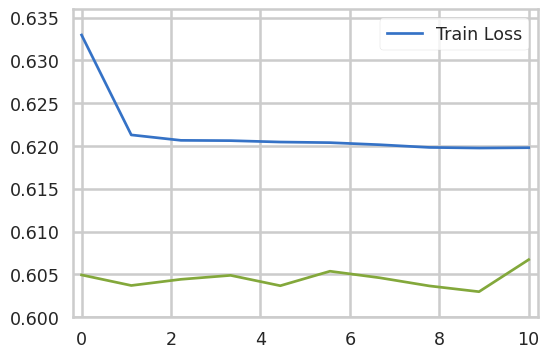

In [17]:
train_losses = []
val_losses = []
for epoch in range(num_epochs):
  model.train()
  iterable_train = iter(train_dataset)
  # shuffle data
  random_permutation = [i for i in range(len(train_dataset.features))]
  shuffle(random_permutation)

  new_train = [iterable_train[i] for i in random_permutation]

  # training loop
  batch_size = batch_size

  train_loss = 0.0
  for i in tqdm.notebook.tqdm(range(0, len(train_dataset.features), batch_size), desc=f"Epoch {epoch}"):
    batch_instances = new_train[i:i+batch_size]
    X_batch = torch.stack([instance.x for instance in batch_instances]).to(device)
    Y_batch = torch.stack([instance.y for instance in batch_instances]).to(device)
    edge_index_batch = batch_instances[0].edge_index.to(device)
    edge_features_batch = batch_instances[0].edge_attr.to(device)

    y_hat = model(X_batch, edge_index_batch, edge_features_batch)
    # when using the lstm model and node_features = 1, you may want to do y_hat = y_hat.squeeze(2) for the shapes to work out
    # y_hat = y_hat.squeeze(2)
    # calculate loss
    loss = torch.sqrt(criterion(Y_batch,y_hat))
    train_loss += loss.item()

    # compute gradients and update parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
        
  
  train_loss /= len(train_dataset.features)/batch_size
  train_losses.append(train_loss)
  # validation loop
  model.eval()
  val_dataset = test_dataset
  iterable_val = iter(val_dataset)
  val_loss = 0.0
  
  with torch.no_grad():
    for i in tqdm.notebook.tqdm(range(0, len(val_dataset.features), batch_size), desc=f"Epoch {epoch} Val"):
      batch_instances = iterable_val[i:i+batch_size]
      X_batch = torch.stack([instance.x for instance in batch_instances]).to(device)
      Y_batch = torch.stack([instance.y for instance in batch_instances]).to(device)
      edge_index_batch = batch_instances[0].edge_index.to(device)
      edge_features_batch = batch_instances[0].edge_attr.to(device)

      y_hat = model(X_batch, edge_index_batch, edge_features_batch)
      y_hat = y_hat.squeeze(2) # for lstm model only
      loss = torch.sqrt(criterion(Y_batch, y_hat))
      val_loss += loss.item()
     

  val_loss /= len(val_dataset.features)/batch_size
  val_losses.append(val_loss)
    
  # print train and validation losses
  print(f"Epoch {epoch} Train Loss: {train_loss:.8f} | Val Loss: {val_loss:.8f}")

  # update the plots
  update_plots(mb, train_losses, val_losses, epoch, num_epochs)

  

    

In [18]:
# save the model for inference later
torch.save(model.state_dict(), 'temporal_gnn_traffic_lstm.pth')